# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [1]:
!pip install ucimlrepo

In [16]:

import ssl
import urllib.request

try:
    # Crear un contexto SSL no verificado
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    # Instalar un "opener" global con este contexto SSL
    https_handler = urllib.request.HTTPSHandler(context=ssl_context)
    opener = urllib.request.build_opener(https_handler)
    urllib.request.install_opener(opener)

    print("✅ Verificación de certificado SSL deshabilitada globalmente.")
    print("🔒 Advertencia: Esto reduce la seguridad. Úsalo solo para fuentes de confianza como UCI.")

except Exception as e:
    print(f"❌ Fallo al deshabilitar la verificación SSL: {e}")
    
from ucimlrepo import fetch_ucirepo
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 



✅ Verificación de certificado SSL deshabilitada globalmente.
🔒 Advertencia: Esto reduce la seguridad. Úsalo solo para fuentes de confianza como UCI.
{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line w

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [3]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [4]:
X["displacement"]

0      307.0
1      350.0
2      318.0
3      304.0
4      302.0
       ...  
393    140.0
394     97.0
395    135.0
396    120.0
397    119.0
Name: displacement, Length: 398, dtype: float64

In [5]:
y["mpg"]

0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
393    27.0
394    44.0
395    32.0
396    28.0
397    31.0
Name: mpg, Length: 398, dtype: float64

In [6]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [7]:
X.shape

(398, 7)

In [8]:
y.shape

(398, 1)

En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

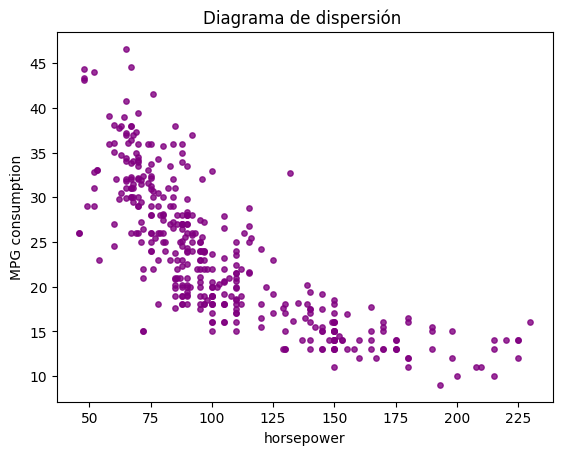

In [9]:
import matplotlib.pyplot as plt

def visualiza(df, y, nombre_columna):

    plt.scatter(df[nombre_columna],y, s=15, c='purple', alpha=0.8)
    plt.title("Diagrama de dispersión ")
    plt.xlabel(f'{nombre_columna}')
    plt.ylabel("MPG consumption")
    plt.show()

visualiza(X, y, 'horsepower')

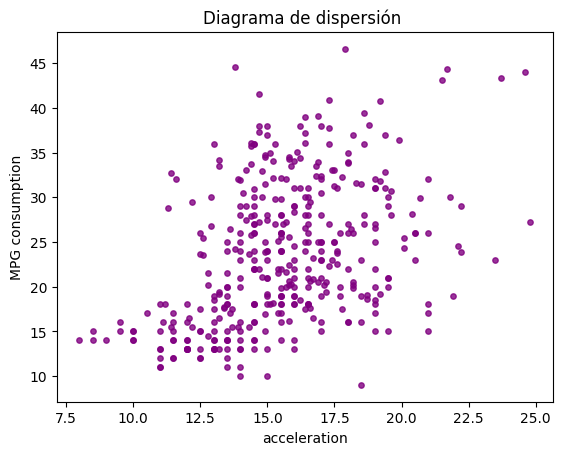

In [10]:
visualiza(X, y, 'acceleration')

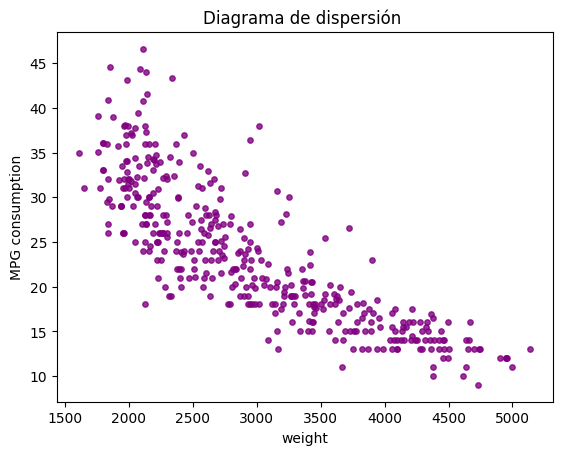

In [11]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [12]:
import numpy as np
O = np.ones([X.shape[0],1])
X_mod = np.concatenate((O,X), axis=1)
X_mod

array([[  1. , 307. ,   8. , ...,  12. ,  70. ,   1. ],
       [  1. , 350. ,   8. , ...,  11.5,  70. ,   1. ],
       [  1. , 318. ,   8. , ...,  11. ,  70. ,   1. ],
       ...,
       [  1. , 135. ,   4. , ...,  11.6,  82. ,   1. ],
       [  1. , 120. ,   4. , ...,  18.6,  82. ,   1. ],
       [  1. , 119. ,   4. , ...,  19.4,  82. ,   1. ]])

In [13]:
import numpy as np

def pesos_ols(X, y):
    
    if X.shape[1] > X.shape[0]:
        X=X.T

    Ones = np.ones([X.shape[0],1])
    X_mod = np.concatenate((Ones,X), axis=1)

    w= np.linalg.inv((X_mod.T @ X_mod)) @ X_mod.T @ y

    return w

In [14]:
# Array de prueba!!
X = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
pesos_ols(X, y)

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

[[ 4.63173644e+01]
 [-7.67661006e-03]]
0      19.418523
1      17.967643
2      19.940532
3      19.963562
4      19.840736
         ...    
393    24.899622
394    29.966185
395    28.699544
396    26.166263
397    25.436985
Name: weight, Length: 398, dtype: float64


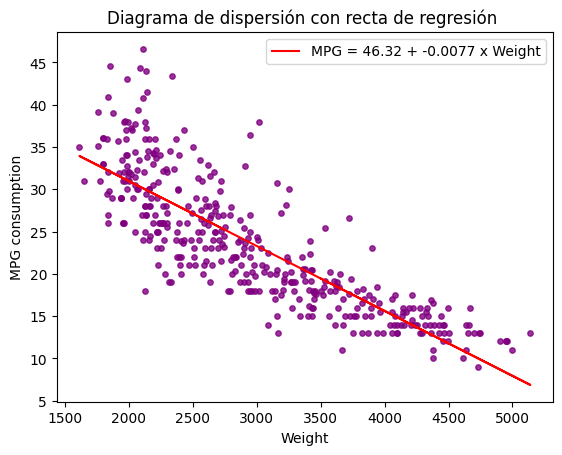

In [19]:
X_array=X['weight'].to_numpy()
X_array_2D=X_array.reshape(X_array.shape[0],1)
y_array=y.to_numpy()

w=pesos_ols(X_array_2D,y_array)
print(w)
Y_fit = w[0]+w[1]*X['weight']
print(Y_fit)

plt.scatter(X['weight'],y, s=15, c='purple', alpha=0.8)
plt.title("Diagrama de dispersión con recta de regresión ")
plt.xlabel(f'{'Weight'}')
plt.ylabel("MPG consumption")
plt.plot(X['weight'], Y_fit, color='red', label=f'MPG = {w[0][0]:.2f} + {w[1][0]:.4f} x Weight')
plt.legend()
plt.show()

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [20]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


Analiza el resultado obtenido y compáralo con el de sklearn: 

El punto de corte (46.317) resultado de aplicar lr se corresponde con el **valor del peso del bias** obtenido de la función de pesos_ols como **$w_0$** (w[0][0])

La pendiente de la recta (-0.007) se corresponde con **$w_1$** (w[1][0]) que es el **valor del peso de la variable weight** obtenido de la función pesos_ols 

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



En teoría los pesos calculados por regresión por mínimos cuadrados y por descenso de gradiente deberían ser los mismos si ambos están aplicados sobre los mismos datos originales. Sin embargo, aquí hemos escalado los datos que se usan en el descenso del gradiente por lo que no salen pesos iguales.

## 2. Optimización con descenso del gradiente

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [121]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta): 
    # Define la función que calcule n_iter iteraciones del descenso del gradiente
    # Inicializamos variables
    # Si eliges otra forma de resolverlo, puedes borrar esta parte
    loss_iter = [np.inf]
    w_iter = [w0]
    w = w0

    #Preparamos la variable con la columans de unos
    Ones = np.ones([X.shape[0],1])
    X_ones = np.concatenate((Ones,X), axis=1)
    
    #iniciamos bucle iteraciones
    n0_iter=1
  
    while n0_iter < n_iter:
        
        w_iter_act = w - eta*(X_ones.T@((X_ones@w)-y)) # calculo el valor de la iteración actual
        w_iter.append(w_iter_act) # actualizo la lista
        w = w_iter_act # reseteo valor de w al siguiente

        loss_iter_act = np.sum((y-(X_ones@w))**2)/2 # calculo el error para esa w de la iteración actual
        loss_iter.append(loss_iter_act) # actualizo la lista
        
        n0_iter += 1
        
    if n0_iter == n_iter:
        print("Has llegado al máximo de iteraciones")
        
    
    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)


eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)

print(weights[-1])

Has llegado al máximo de iteraciones
[[183845.82320222]
 [ 40415.66453324]]


### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [122]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

(398, 1)
Has llegado al máximo de iteraciones
[23.51457286]


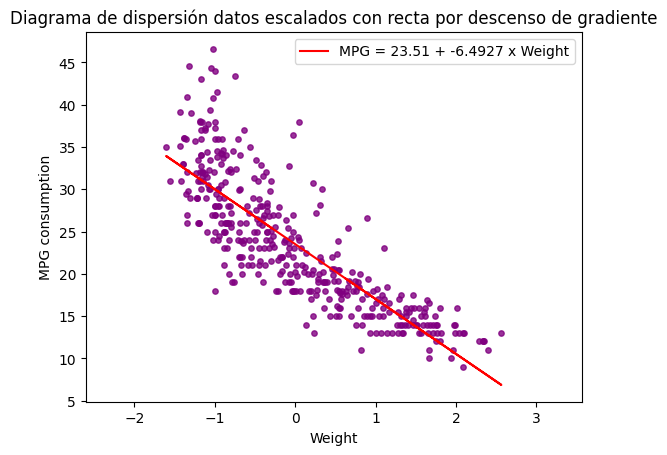

In [ ]:
# Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np
print(y_gd.shape)

# Punto inicial y learning rate
eta = 0.005
iteraciones = 2000
np.random.seed(123)
w0 = np.random.rand(2).reshape(2,1)

# Aplicamos el algoritmo

weights, loss = gradient_descent(X_gd, y_gd, w0, iteraciones, eta)

print(weights[-1][0])

#Límites de los ejes
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) -1

Y_fit = weights[-1][0]+weights[-1][1]*X_gd
# Dibuja la gráfica

plt.scatter(X_gd,y_gd, s=15, c='purple', alpha=0.8)
plt.title("Diagrama de dispersión datos escalados con recta por descenso de gradiente")
plt.xlabel(f'{'Weight'}')
plt.ylabel("MPG consumption")
plt.plot(X_gd,Y_fit,color='red',label=f"MPG = {weights[-1][0][0]:.2f} + {weights[-1][1][0]:.4f} x Weight")
plt.xlim(x_min, x_max)
plt.legend()
plt.show()
